Train columns: Index(['ID', '外資券商_分點進出', '外資券商_分點買賣力', '外資券商_分點成交力(%)', '外資券商_分點吃貨比(%)',
       '外資券商_分點出貨比(%)', '外資券商_前1天分點進出', '外資券商_前1天分點買賣力', '外資券商_前1天分點成交力(%)',
       '外資券商_前1天分點吃貨比(%)',
       ...
       '上市加權指數前15天成交量', '上市加權指數前16天成交量', '上市加權指數前17天成交量', '上市加權指數前18天成交量',
       '上市加權指數前19天成交量', '上市加權指數前20天成交量', '上市加權指數5天成交量波動度', '上市加權指數10天成交量波動度',
       '上市加權指數20天成交量波動度', '飆股'],
      dtype='object', length=10214)
Public X columns: Index(['ID', '外資券商_分點進出', '外資券商_分點買賣力', '外資券商_分點成交力(%)', '外資券商_分點吃貨比(%)',
       '外資券商_分點出貨比(%)', '外資券商_前1天分點進出', '外資券商_前1天分點買賣力', '外資券商_前1天分點成交力(%)',
       '外資券商_前1天分點吃貨比(%)',
       ...
       '上市加權指數前14天成交量', '上市加權指數前15天成交量', '上市加權指數前16天成交量', '上市加權指數前17天成交量',
       '上市加權指數前18天成交量', '上市加權指數前19天成交量', '上市加權指數前20天成交量', '上市加權指數5天成交量波動度',
       '上市加權指數10天成交量波動度', '上市加權指數20天成交量波動度'],
      dtype='object', length=10213)
最佳閾值: 0.8679


C:\Users\leonl\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leonl\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leonl\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21152 (\N{CJK UNIFIED IDEOGRAPH-52A0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leonl\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27402 (\N{CJK UNIFIED IDEOGRAPH-6B0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\leonl\AppData\Local\Programs\Python

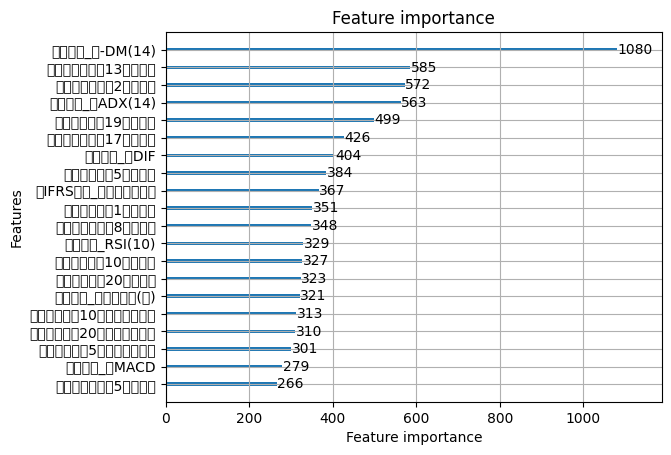

Prediction saved to result.csv


In [2]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_recall_curve
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 讀取資料
train_df = pd.read_csv("training.csv")
public_x = pd.read_csv("public_x.csv")
submission_template = pd.read_csv("submission_template_public.csv")

# 檢查欄位
print("Train columns:", train_df.columns)
print("Public X columns:", public_x.columns)

# 移除缺失率 > 70% 的欄位
train_df = train_df.loc[:, train_df.isnull().mean() < 0.7]

# 保留非空率前 300 名特徵 + 標籤欄位
non_null_ratio = train_df.notnull().mean().sort_values(ascending=False)
top_columns = non_null_ratio.head(300).index.tolist()
if "飆股" not in top_columns:
    top_columns.append("飆股")
train_df = train_df[top_columns]

# 去除非數值欄位 + 切分資料
train_df = train_df.select_dtypes(include=["number"])
X = train_df.drop(columns=["飆股"])
y = train_df["飆股"]

# 若 y 中只有一類，直接跳出提示
if y.nunique() < 2:
    raise ValueError("資料中僅包含單一類別，無法訓練模型")

# 填補缺失值（中位數）
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 同樣處理 public_x 資料
public_x = public_x[X.columns]
X_test = pd.DataFrame(imputer.transform(public_x), columns=public_x.columns)

# 計算 scale_pos_weight
scale_pos_weight = (len(y) - y.sum()) / y.sum()

# 使用 Stratified K-Fold 交叉驗證
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_thresholds = []

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # 建立 LGBM 資料集
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # 設定 LGBM 參數
    params = {
        "objective": "binary",
        "metric": "recall",
        "boosting_type": "gbdt",
        "learning_rate": 0.01,  # 降低學習率，提高穩定性
        "num_leaves": 31,
        "max_depth": -1,
        "verbose": -1,
        "scale_pos_weight": scale_pos_weight,  # 平衡類別
        "num_iterations": 1000,  # 增加訓練次數
    }

    model = lgb.train(params, train_data, valid_sets=[valid_data])

    # 預測 + 選擇最佳閾值
    y_probs = model.predict(X_valid)
    precisions, recalls, thresholds = precision_recall_curve(y_valid, y_probs)

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_threshold = thresholds[np.nanargmax(f1_scores)]  # 找到最高 F1-score 的閾值
    best_thresholds.append(best_threshold)

# 計算最終最佳閾值
final_threshold = np.mean(best_thresholds)
print(f"最佳閾值: {final_threshold:.4f}")

# 重新訓練模型（使用全部數據）
train_data = lgb.Dataset(X, label=y)
final_model = lgb.train(params, train_data)

# 預測 public_x 並套用最佳閾值
public_preds = final_model.predict(X_test)
public_preds_binary = (public_preds > final_threshold).astype(int)

# 輸出特徵重要性
plt.rcParams['font.sans-serif'] = ['SimHei']
lgb.plot_importance(final_model, max_num_features=20)
plt.show()

# 產出結果
submission_template["飆股"] = public_preds_binary
submission_template.to_csv("result.csv", index=False)
print("Prediction saved to result.csv")

In [ ]:
public_preds = model.predict(X_test)
public_preds_binary = (public_preds > 0.891).astype(int)

# 產出結果
submission_template["飆股"] = public_preds_binary
submission_template.to_csv("result.csv", index=False)
print("Prediction saved to result.csv")
print("Submission template 飆股比例:", submission_template["飆股"].mean())

In [31]:
y.sum()/(len(y) - y.sum()) 

np.float64(0.00737233818469964)